# Klaszterezés, többváltozós lineáris regresszió - Lakatos Áron
## Kiadó budapesti lakások elemzése, illetve ajánlat készítése a környékben lévő létesítmények figyelembevételével

In [1]:
#Szükséges könyvtárak importálása
import numpy as np
import pandas as pd
import json

#set max display width to none for pandas dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#API használat
import requests
from requests import get
from pandas.io.json import json_normalize

#matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# k-közép klaszterezéshez
from sklearn.cluster import KMeans

# Regresszióhoz
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score


#a térképes megjelenítésekhez installálni!
#!conda install -c conda-forge folium=0.5.0 --yes 
#!pip install folium
import folium

# diagramok
import seaborn as sns

print('Library-k importálva.')

Library-k importálva.


## A szükséges adatállományok előkészítése, adattisztítás

In [2]:
df_full = pd.read_csv(r'C:\Users\36307\Documents\notebooks\flats.csv', index_col=None, header=0)

In [4]:
df_full.head()

,Unnamed: 0,animals,common_cost,condition,date_scraped,description,elevator,energy_certificate,furniture,garden,heating_type,image_folder_name,image_urls,location,location_str,price,rooms,size,title,type,url,view_type
0,https://ingatlan.jofogas.hu/budapest/07_01_tol...,nem,15000 ft/hó,új építésű,2018/05/06 14:50,Újnak LÁtszÓ (a valóságban 7 éves) BelvÁrosi...,van,a,igen,nem,egyedi mérős központifűtés,e1db7b7b-590d-4c73-ac90-881cd9a30f01,['https://img.jofogas.hu/hdimages/07_01_tol_be...,"(47.5101199, 19.0936737)","Budapest, XIV. kerület, Istvánmező, Thököly...",148000.0,2.0,60.0,"07.01-től belvárosi, 2 szobás berendezett laká...",tégla,https://ingatlan.jofogas.hu/budapest/07_01_tol...,panoráma
1,https://ingatlan.jofogas.hu/budapest/100m2__es...,nem,NaN,felújított,2018/05/06 15:30,Kertvárosi környezetben 4 lakásos társasházb...,nincs,NaN,megegyezés szerint,igen,gáz-cirkó,908b3451-c6d2-40cb-969a-3651110bf3d2,['https://img.jofogas.hu/hdimages/100m2__es_2_...,"(47.5498939, 19.1262642)","Budapest, XV. kerület, Rákospalota, Dessewf...",170000.0,2.0,100.0,"100m2 -es 2,5 szobás lakás Rákospalotán kiadó",tégla,https://ingatlan.jofogas.hu/budapest/100m2__es...,udvari
2,https://ingatlan.jofogas.hu/budapest/106_nm_es...,NaN,NaN,jó állapotú,2018/05/06 14:42,"VII. kerület, Izabella utcában, közös haszná...",van,NaN,igen,NaN,gáz-cirkó,7fac6aad-0d90-4217-8fe2-d2ba0cf2e4dc,['https://img.jofogas.hu/hdimages/106_nm_es__3...,"(47.501195, 19.0711858)","Budapest, VII. kerület, VII. Kerület",190000.0,3.0,106.0,"106 nm-es, 3 szobás, bútorozott, gépesített la...",tégla,https://ingatlan.jofogas.hu/budapest/106_nm_es...,utcai
3,https://ingatlan.jofogas.hu/budapest/106_nm_es...,NaN,NaN,jó állapotú,2018/05/06 14:43,"VII. kerület, Izabella utcában, közös haszná...",van,NaN,igen,NaN,gáz-cirkó,8f9c7d15-a80c-43ae-9b6f-cede11dac08d,['https://img.jofogas.hu/hdimages/106_nm_es__3...,"(47.501195, 19.0711858)","Budapest, VII. kerület, VII. Kerület",190000.0,3.0,106.0,"106 nm-es, 3 szobás, bútorozott, gépesített la...",tégla,https://ingatlan.jofogas.hu/budapest/106_nm_es...,utcai
4,https://ingatlan.jofogas.hu/budapest/106_nm_es...,csak kisebb méretű háziállatok,16000 ft/hó,jó állapotú,2018/05/06 14:55,"V. ker. Kossuth Lajos utca mellékutcájában, ...",van,NaN,nem,NaN,gáz-cirkó,6c61cd28-9595-4471-a4b9-9710bda5551f,['https://img.jofogas.hu/hdimages/106_nm_es_la...,"(47.4950949, 19.0539535)","Budapest, V. kerület",372132.0,3.0,106.0,106 nm-es lakás kiadó Budapest 5. ker. #2269814,tégla,https://ingatlan.jofogas.hu/budapest/106_nm_es...,utcai


In [5]:
keruletek = pd.read_csv(r'C:\Users\36307\Documents\notebooks\keruletek.csv', index_col=None, header=0)
keruletek.drop(['Unnamed: 3'], axis=1, inplace = True)

In [6]:
keruletek.head()

,District,Lat,Lon
0,Budapest I. kerulete,47.496819,19.034522
1,Budapest II. kerulete,47.527676,19.002645
2,Budapest III. kerulete,47.570096,19.037062
3,Budapest IV. kerulete,47.572625,19.082388
4,Budapest V. kerulete,47.501275,19.048857


### Klaszterezéshez előkészítjük az adatokat

In [7]:
df = df_full[['location', 'location_str', 'price', 'size']]

In [8]:
df.columns = ['Coordinates', 'Location', 'Price', 'Size']

In [9]:
df['Price/m2'] = (df['Price']/df['Size']).round(2)

C:\Users\36307\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
df.head()

,Coordinates,Location,Price,Size,Price/m2
0,"(47.5101199, 19.0936737)","Budapest, XIV. kerület, Istvánmező, Thököly...",148000.0,60.0,2466.67
1,"(47.5498939, 19.1262642)","Budapest, XV. kerület, Rákospalota, Dessewf...",170000.0,100.0,1700.00
2,"(47.501195, 19.0711858)","Budapest, VII. kerület, VII. Kerület",190000.0,106.0,1792.45
3,"(47.501195, 19.0711858)","Budapest, VII. kerület, VII. Kerület",190000.0,106.0,1792.45
4,"(47.4950949, 19.0539535)","Budapest, V. kerület",372132.0,106.0,3510.68


In [11]:
locations = df["Coordinates"]
locations = [list(eval(x)) for x in locations]

loc = np.array(list(zip(*locations)))
lat = loc[0]
lon = loc[1]

# None értékek 0-ra alakítása, különben hibát dob a térképes megjelenítő
lat[np.where(lat==None)] = 0
lon[np.where(lon==None)] = 0

In [12]:
df['Latitude'] = lat
df['Longitude'] = lon
df.drop(['Coordinates'], axis = 1, inplace=True)
df.head()

C:\Users\36307\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\36307\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\36307\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

,Location,Price,Size,Price/m2,Latitude,Longitude
0,"Budapest, XIV. kerület, Istvánmező, Thököly...",148000.0,60.0,2466.67,47.5101,19.0937
1,"Budapest, XV. kerület, Rákospalota, Dessewf...",170000.0,100.0,1700.00,47.5499,19.1263
2,"Budapest, VII. kerület, VII. Kerület",190000.0,106.0,1792.45,47.5012,19.0712
3,"Budapest, VII. kerület, VII. Kerület",190000.0,106.0,1792.45,47.5012,19.0712
4,"Budapest, V. kerület",372132.0,106.0,3510.68,47.4951,19.054


### Hozzáadok egy új változót, amit úgy kapok, hogy a kerületek pontos neveit kiszedem a Location mezőből

In [13]:
df['District'] = ''
df.head()

C:\Users\36307\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Location,Price,Size,Price/m2,Latitude,Longitude,District
0,"Budapest, XIV. kerület, Istvánmező, Thököly...",148000.0,60.0,2466.67,47.5101,19.0937,
1,"Budapest, XV. kerület, Rákospalota, Dessewf...",170000.0,100.0,1700.00,47.5499,19.1263,
2,"Budapest, VII. kerület, VII. Kerület",190000.0,106.0,1792.45,47.5012,19.0712,
3,"Budapest, VII. kerület, VII. Kerület",190000.0,106.0,1792.45,47.5012,19.0712,
4,"Budapest, V. kerület",372132.0,106.0,3510.68,47.4951,19.054,


In [14]:
# Ez a függvény a budapesti kerületeket rendeli hozzá az egyes albérletekhez
def districts(df):
    df.loc[df['Location'].str.contains('Budapest, I. kerület'), 'District'] = 'Budapest I. kerulete'
    df.loc[df['Location'].str.contains('Budapest, II. kerület'), 'District'] = 'Budapest II. kerulete'
    df.loc[df['Location'].str.contains('Budapest, III. kerület'), 'District'] = 'Budapest III. kerulete'
    df.loc[df['Location'].str.contains('Budapest, IV. kerület'), 'District'] = 'Budapest IV. kerulete'
    df.loc[df['Location'].str.contains('Budapest, V. kerület'), 'District'] = 'Budapest V. kerulete'
    df.loc[df['Location'].str.contains('Budapest, VI. kerület'), 'District'] = 'Budapest VI. kerulete'
    df.loc[df['Location'].str.contains('Budapest, VII. kerület'), 'District'] = 'Budapest VII. kerulete'
    df.loc[df['Location'].str.contains('Budapest, VIII. kerület'), 'District'] = 'Budapest VIII. kerulete'
    df.loc[df['Location'].str.contains('Budapest, IX. kerület'), 'District'] = 'Budapest IX. kerulete'
    df.loc[df['Location'].str.contains('Budapest, X. kerület'), 'District'] = 'Budapest X. kerulete'
    df.loc[df['Location'].str.contains('Budapest, XI. kerület'), 'District'] = 'Budapest XI. kerulete'
    df.loc[df['Location'].str.contains('Budapest, XII. kerület'), 'District'] = 'Budapest XII. kerulete'
    df.loc[df['Location'].str.contains('Budapest, XIII. kerület'), 'District'] = 'Budapest XIII. kerulete'
    df.loc[df['Location'].str.contains('Budapest, XIV. kerület'), 'District'] = 'Budapest XIV. kerulete'
    df.loc[df['Location'].str.contains('Budapest, XV. kerület'), 'District'] = 'Budapest XV. kerulete'
    df.loc[df['Location'].str.contains('Budapest, XVI. kerület'), 'District'] = 'Budapest XVI. kerulete'
    df.loc[df['Location'].str.contains('Budapest, XVII. kerület'), 'District'] = 'Budapest XVII. kerulete'
    df.loc[df['Location'].str.contains('Budapest, XVIII. kerület'), 'District'] = 'Budapest XVIII. kerulete'
    df.loc[df['Location'].str.contains('Budapest, XIX. kerület'), 'District'] = 'Budapest XIX. kerulete'
    df.loc[df['Location'].str.contains('Budapest, XX. kerület'), 'District'] = 'Budapest XX. kerulete'
    df.loc[df['Location'].str.contains('Budapest, XXI. kerület'), 'District'] = 'Budapest XXI. kerulete'
    df.loc[df['Location'].str.contains('Budapest, XXII. kerület'), 'District'] = 'Budapest XXII. kerulete'
    df.loc[df['Location'].str.contains('Budapest, XXIII. kerület'), 'District'] = 'Budapest XXIII. kerulete'

In [15]:
districts(df)
df.drop(['Location'], axis = 1, inplace = True)
df.head()

C:\Users\36307\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Price,Size,Price/m2,Latitude,Longitude,District
0,148000.0,60.0,2466.67,47.5101,19.0937,Budapest XIV. kerulete
1,170000.0,100.0,1700.00,47.5499,19.1263,Budapest XV. kerulete
2,190000.0,106.0,1792.45,47.5012,19.0712,Budapest VII. kerulete
3,190000.0,106.0,1792.45,47.5012,19.0712,Budapest VII. kerulete
4,372132.0,106.0,3510.68,47.4951,19.054,Budapest V. kerulete


In [16]:
#Ellenőrzás, hogy minden kerületben van-e albérlet
df['District'].unique().tolist()

['Budapest XIV. kerulete',
 'Budapest XV. kerulete',
 'Budapest VII. kerulete',
 'Budapest V. kerulete',
 'Budapest VIII. kerulete',
 'Budapest XIII. kerulete',
 'Budapest III. kerulete',
 'Budapest XVI. kerulete',
 'Budapest XI. kerulete',
 'Budapest XXII. kerulete',
 'Budapest II. kerulete',
 'Budapest XII. kerulete',
 'Budapest XVIII. kerulete',
 'Budapest IX. kerulete',
 'Budapest VI. kerulete',
 'Budapest XX. kerulete',
 'Budapest X. kerulete',
 'Budapest IV. kerulete',
 'Budapest XIX. kerulete',
 'Budapest I. kerulete',
 'Budapest XVII. kerulete',
 'Budapest XXI. kerulete',
 'Budapest XXIII. kerulete']

### A hiányzó adatok kezelése

In [17]:
missing_data = df.isna()
missing_data.head(5)

,Price,Size,Price/m2,Latitude,Longitude,District
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False


In [18]:
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")

Price
False    2812
True       32
Name: Price, dtype: int64

Size
False    2843
True        1
Name: Size, dtype: int64

Price/m2
False    2811
True       33
Name: Price/m2, dtype: int64

Latitude
False    2844
Name: Latitude, dtype: int64

Longitude
False    2844
Name: Longitude, dtype: int64

District
False    2844
Name: District, dtype: int64



In [19]:
#hiányzó értéket tartalmazó sorok eldobása, mivel nem veszítünk túl sokat
df.dropna(inplace= True)
df.shape

C:\Users\36307\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(2811, 6)

## A kiugró értékek kezelése
### A Price/m2 mező értékkészletének vizsgálatával kezdem

In [20]:
# Price/m2 értékek top 20 előfordulása
price = df["Price/m2"]
sorted(price, reverse=True)[:20]

[1435552.11,
 1000000.0,
 687777.78,
 588000.0,
 500000.0,
 13333.33,
 13135.59,
 11111.11,
 10544.78,
 9983.33,
 9472.22,
 9432.0,
 9348.61,
 8379.47,
 8333.33,
 8333.33,
 8266.67,
 8207.5,
 8000.0,
 7969.54]

In [21]:
# 20 legkisebb érték a Price/m2 változóban
price = df["Price/m2"]
sorted(price, reverse=False)[:20]

[2.89,
 3.0,
 10.0,
 17.68,
 170.21,
 263.16,
 267.86,
 333.33,
 647.06,
 700.0,
 901.96,
 1176.47,
 1272.73,
 1368.42,
 1399.01,
 1416.67,
 1416.67,
 1428.57,
 1451.61,
 1454.55]

In [22]:
# Legfelső és legalsó 0,5% határa
q_low = df["Price/m2"].quantile(0.005)
q_hi  = df["Price/m2"].quantile(0.995)
print(q_low)
print(q_hi)

1399.893
8333.33


#### Teljes adattábla vizsgálata a Price/m2 mező alapján rendezve

In [23]:
# Nézzük a teljes adattáblát a Price/m2 szerint rendezve csökkenőre
df.sort_values('Price/m2', ascending = False).head(10)

,Price,Size,Price/m2,Latitude,Longitude,District
427,136377450.0,95.0,1435552.11,47.5193,19.0058,Budapest II. kerulete
2202,65000000.0,65.0,1000000.00,47.4924,19.054,Budapest V. kerulete
2105,61900000.0,90.0,687777.78,47.5107,19.0747,Budapest VI. kerulete
583,58800000.0,100.0,588000.00,47.5596,18.9557,Budapest II. kerulete
2386,45000000.0,90.0,500000.00,47.5107,19.0747,Budapest VI. kerulete
24,160000.0,12.0,13333.33,47.5403,19.0845,Budapest XIII. kerulete
1722,1550000.0,118.0,13135.59,47.5158,19.053,Budapest XIII. kerulete
1381,500000.0,45.0,11111.11,47.512,19.0267,Budapest II. kerulete
1344,1413000.0,134.0,10544.78,47.5045,19.0504,Budapest V. kerulete
482,599000.0,60.0,9983.33,47.4951,19.054,Budapest V. kerulete


In [24]:
# Nézzük a teljes adattáblát a Price/m2 szerint rendezve növekvőre
df.sort_values('Price/m2', ascending = True).head(10)

,Price,Size,Price/m2,Latitude,Longitude,District
2737,130000.0,45000.0,2.89,47.5063,19.1038,Budapest XIV. kerulete
2002,120.0,40.0,3.00,47.4834,19.1383,Budapest X. kerulete
2044,1500.0,150.0,10.00,47.5041,19.0326,Budapest I. kerulete
1524,45000.0,2545.0,17.68,47.5298,19.0809,Budapest XIII. kerulete
2402,8000.0,47.0,170.21,47.5118,19.1138,Budapest XIV. kerulete
2047,20000.0,76.0,263.16,47.5003,19.0375,Budapest I. kerulete
2005,15000.0,56.0,267.86,47.4764,19.0224,Budapest XI. kerulete
2302,10000.0,30.0,333.33,47.5063,19.1038,Budapest XIV. kerulete
2000,55000.0,85.0,647.06,47.4798,19.048,Budapest VIII. kerulete
234,35000.0,50.0,700.00,47.51,19.1217,Budapest XIV. kerulete


In [25]:
df = df[(df["Price/m2"] < 12000) & (df["Price/m2"] > 400)]

In [26]:
df.sort_values('Price', ascending = False).head()

,Price,Size,Price/m2,Latitude,Longitude,District
1024,1675000.0,358.0,4678.77,47.5114,19.0662,Budapest VI. kerulete
1247,1570000.0,197.0,7969.54,47.5114,19.0662,Budapest VI. kerulete
1810,1550000.0,500.0,3100.00,47.5114,19.0662,Budapest VI. kerulete
813,1513267.0,263.0,5753.87,47.5045,19.0504,Budapest V. kerulete
1344,1413000.0,134.0,10544.78,47.5045,19.0504,Budapest V. kerulete


In [27]:
df.sort_values('Price').head()

,Price,Size,Price/m2,Latitude,Longitude,District
234,35000.0,50.0,700.0,47.51,19.1217,Budapest XIV. kerulete
39,40000.0,20.0,2000.0,47.5298,19.0809,Budapest XIII. kerulete
2024,40000.0,25.0,1600.0,47.5065,19.0607,Budapest VI. kerulete
250,40000.0,20.0,2000.0,47.5499,19.1263,Budapest XV. kerulete
249,45000.0,30.0,1500.0,47.5458,19.0384,Budapest III. kerulete


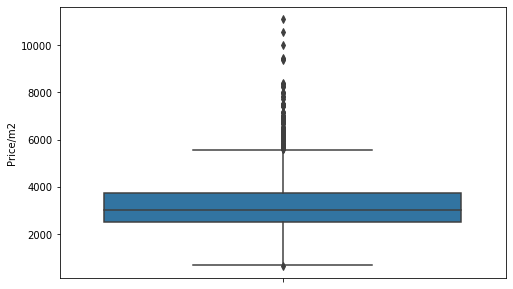

In [28]:
plt.figure(figsize=(8,5))
sns.boxplot(y='Price/m2', data=df)

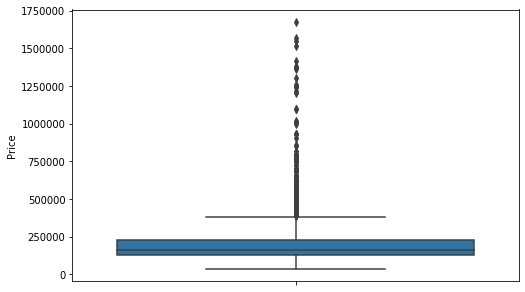

In [29]:
plt.figure(figsize=(8,5))
sns.boxplot(y='Price', data=df)

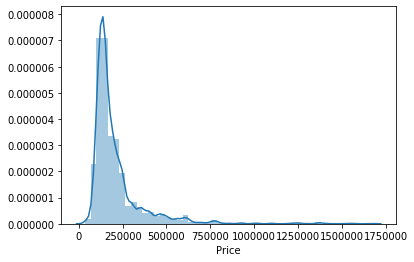

In [30]:
sns.distplot(df['Price'])

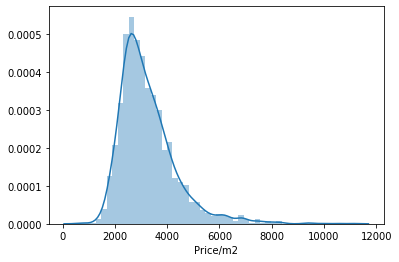

In [31]:
sns.distplot(df['Price/m2'])

In [32]:
sizes = df["Size"]
sorted(sizes, reverse=True)[:10]

[500.0, 389.0, 384.0, 365.0, 358.0, 300.0, 291.0, 280.0, 270.0, 263.0]

In [33]:
sizes = df["Size"]
sorted(sizes, reverse=False)[:10]

[12.0, 12.0, 12.0, 14.0, 15.0, 15.0, 15.0, 15.0, 16.0, 18.0]

In [34]:
df.sort_values('Size').head(15)

,Price,Size,Price/m2,Latitude,Longitude,District
475,45000.0,12.0,3750.00,47.5332,19.0362,Budapest III. kerulete
2364,65000.0,12.0,5416.67,47.4222,19.2033,Budapest XVIII. kerulete
1572,100000.0,12.0,8333.33,47.5053,19.0826,Budapest VII. kerulete
2218,85000.0,14.0,6071.43,47.5596,18.9557,Budapest II. kerulete
1362,50000.0,15.0,3333.33,47.5716,19.0866,Budapest IV. kerulete
996,90000.0,15.0,6000.00,47.5117,19.0695,Budapest VI. kerulete
2219,100000.0,15.0,6666.67,47.4847,19.0765,Budapest VIII. kerulete
9,50000.0,15.0,3333.33,47.541,19.1453,Budapest XV. kerulete
2077,80000.0,16.0,5000.00,47.5918,19.0583,Budapest III. kerulete
281,70000.0,18.0,3888.89,47.4981,19.0655,Budapest VII. kerulete


In [35]:
# Úgy gondolom, hogy 20 m2-nél kisebb, illetve az extrém nagy lakásokat nem szeretnék az elemzésembe belefoglalni, lakhatatlannak veszem őket
df = df[(df["Size"] > 20) & (df["Size"] < 300)]

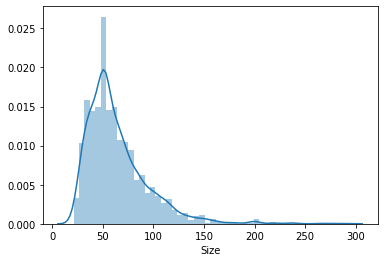

In [36]:
sns.distplot(df['Size'])

In [37]:
df.shape

(2769, 6)

In [38]:
print('{} lakás található az adathalmazban.'.format(df.shape[0]))

2769 lakás található az adathalmazban.


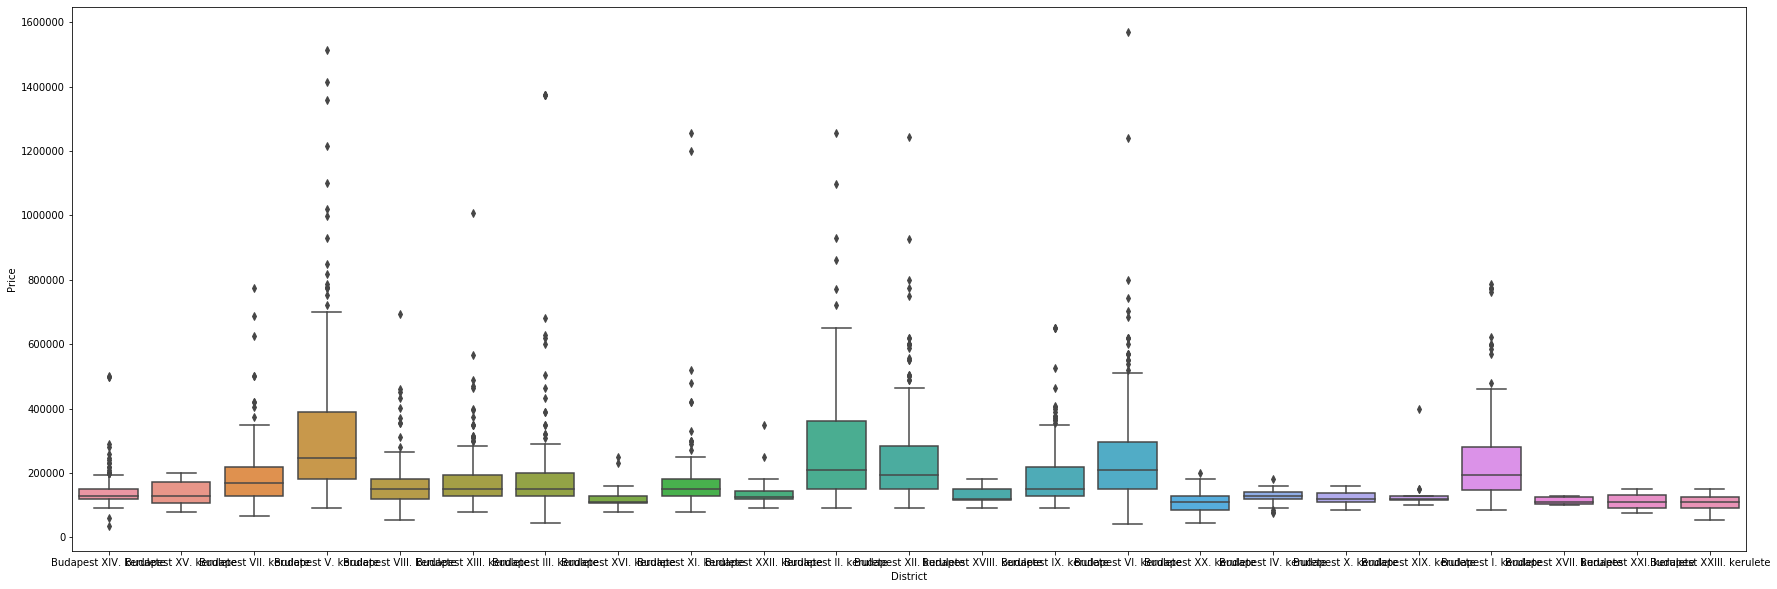

In [39]:
# Megjelenítettem az árakat kerületenként
plt.figure(figsize=(30,10))
sns.boxplot(x='District', y='Price', data=df)

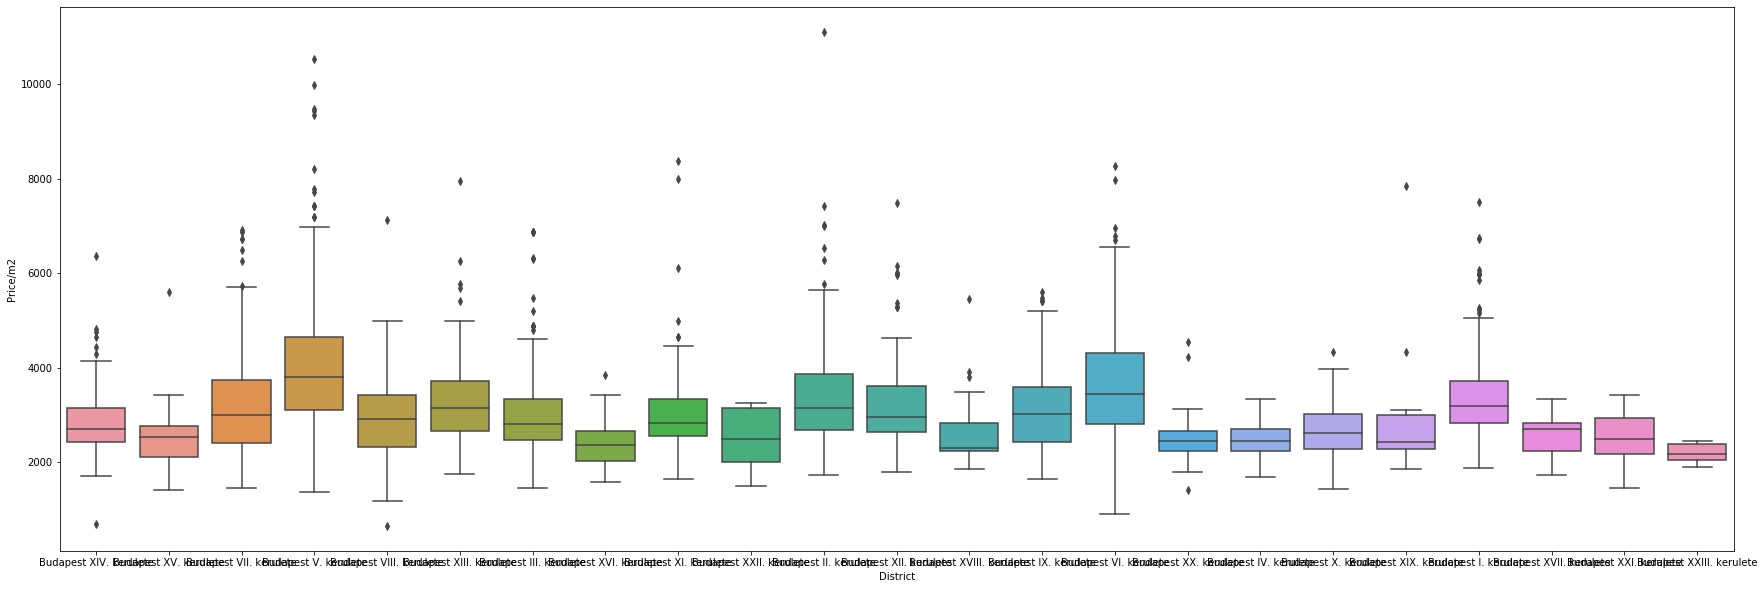

In [40]:
# kerületenként az Ár/m2 alakulása
plt.figure(figsize=(30,10))
sns.boxplot(x='District', y='Price/m2', data=df)

In [41]:
df.describe()

,Price,Size,Price/m2
count,2.769000e+03,2769.000000,2769.000000
mean,2.086312e+05,63.946912,3238.120813
std,1.515488e+05,30.937864,1074.178976
min,3.500000e+04,21.000000,647.060000
25%,1.300000e+05,44.000000,2500.000000
50%,1.600000e+05,56.000000,3000.000000
75%,2.300000e+05,76.000000,3714.290000
max,1.570000e+06,291.000000,11111.110000


## Melyik kerületben, hány kiadó lakás található:

In [42]:
df['District'].value_counts()

Budapest V. kerulete        327
Budapest XIII. kerulete     272
Budapest VI. kerulete       250
Budapest VII. kerulete      235
Budapest XIV. kerulete      216
Budapest XI. kerulete       212
Budapest II. kerulete       205
Budapest VIII. kerulete     202
Budapest IX. kerulete       176
Budapest III. kerulete      150
Budapest XII. kerulete      140
Budapest I. kerulete        123
Budapest IV. kerulete        54
Budapest XVIII. kerulete     41
Budapest X. kerulete         38
Budapest XVI. kerulete       26
Budapest XX. kerulete        21
Budapest XV. kerulete        20
Budapest XIX. kerulete       18
Budapest XXII. kerulete      15
Budapest XXI. kerulete       15
Budapest XVII. kerulete       7
Budapest XXIII. kerulete      6
Name: District, dtype: int64

In [43]:
# Heatmap-en
from folium import plugins

BUDAPEST_CENTER = (47.4979, 19.0402)

budapest_map = folium.Map(location=BUDAPEST_CENTER,tiles = "Stamen Toner", zoom_start = 10)
budapest_map.add_child(plugins.HeatMap(list(zip(df['Latitude'], df['Longitude'])), radius=8))

## A kerületek sorrendje Ár/m2 szerint rendezve a következő:

In [44]:
tempdf = df.groupby('District').mean().reset_index()

In [45]:
tempdf.sort_values(by='Price/m2', ascending=False)

,District,Price,Size,Price/m2
5,Budapest V. kerulete,310687.336391,76.376147,4062.948563
6,Budapest VI. kerulete,250112.108000,68.960000,3625.957320
1,Budapest II. kerulete,278012.063415,80.243902,3400.325073
0,Budapest I. kerulete,245088.227642,72.170732,3395.196098
12,Budapest XIII. kerulete,174032.323529,54.367647,3242.865478
11,Budapest XII. kerulete,260719.542857,78.514286,3232.476571
7,Budapest VII. kerulete,186481.327660,61.489362,3201.294000
4,Budapest IX. kerulete,189058.045455,63.187500,3097.740455
2,Budapest III. kerulete,213905.120000,64.266667,3094.314667
10,Budapest XI. kerulete,171801.509434,56.301887,3041.072123


## Kerületek ábrázolása geojson file segítségével, megjelenítve a kerületenkénti Ár/m2-t

In [46]:
# geojson file megnyitása
with open(r'C:\Users\36307\Documents\notebooks\kerulet_polygon_javitott.geojson') as json_data:
    location_data = json.load(json_data)

In [47]:
mean_per_district = df.groupby('District').mean().reset_index()
mean_per_district

,District,Price,Size,Price/m2
0,Budapest I. kerulete,245088.227642,72.170732,3395.196098
1,Budapest II. kerulete,278012.063415,80.243902,3400.325073
2,Budapest III. kerulete,213905.120000,64.266667,3094.314667
3,Budapest IV. kerulete,126759.259259,52.462963,2469.308704
4,Budapest IX. kerulete,189058.045455,63.187500,3097.740455
5,Budapest V. kerulete,310687.336391,76.376147,4062.948563
6,Budapest VI. kerulete,250112.108000,68.960000,3625.957320
7,Budapest VII. kerulete,186481.327660,61.489362,3201.294000
8,Budapest VIII. kerulete,162985.816832,59.118812,2931.291634
9,Budapest X. kerulete,122105.263158,47.921053,2722.653947


In [48]:
# Budapest térkép
bp_geo = location_data

# Sima térkép behívása Budapestről
district_map = folium.Map(location=BUDAPEST_CENTER, zoom_start=12)

# adat hozzáadása
district_map.choropleth(
    geo_data=location_data,
    data=mean_per_district,
    columns=['District', 'Price/m2'],
    key_on='feature.geometry.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Átlagos Ár/m2 Budapesten kerületenként'
)

# Címkék
for lat, lng, district in zip(keruletek['Lat'], keruletek['Lon'], keruletek['District']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=100,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(district_map) 

# display map
district_map

In [49]:
# geojson tartalma:
location_data['features']

[{'type': 'Feature',
  'geometry': {'type': 'Polygon',
   'name': 'Budapest II. kerulete',
   'coordinates': [[[19.0172675, 47.532714],
     [19.0173049, 47.5325722],
     [19.0173368, 47.5322881],
     [19.0173368, 47.5322881],
     [19.0173368, 47.5322881],
     [19.0173368, 47.5322881],
     [19.0173487, 47.5321608],
     [19.0175271, 47.5311409],
     [19.0175652, 47.5308284],
     [19.0175652, 47.5308284],
     [19.0176084, 47.5304531],
     [19.0176874, 47.5297875],
     [19.0177346, 47.5296657],
     [19.0177346, 47.5296657],
     [19.0177346, 47.5296657],
     [19.0177346, 47.5296657],
     [19.0177359, 47.5296312],
     [19.0177231, 47.5296034],
     [19.017694, 47.5295718],
     [19.017694, 47.5295718],
     [19.017694, 47.5295718],
     [19.017694, 47.5295718],
     [19.017719, 47.5295909],
     [19.0177518, 47.5296036],
     [19.0177889, 47.5296084],
     [19.0178267, 47.5296048],
     [19.0178606, 47.529593],
     [19.0179196, 47.5295736],
     [19.0180062, 47.5295616],
  

## Foursquare API lekérdezés
#### Ennek segítségével megkapjuk az adott kerületben található létesítményeket. Tartalmazhat szórakozóhelyeket, sportlétesítményeket, éttermeket, busz-, vonatállomásokat stb.

In [50]:
# Foursquare API lekérdezésekhez accountomhoz tartozó stringek
CLIENT_ID = 'T0DVBOXJE1O2NLYEY350OFNH5LA3KHKFVZGKDTF2H4OCUBNW' # your Foursquare ID
CLIENT_SECRET = 'VJHQX4HURLN1BLPVIWHFB2DKUVWPSVWKDKLAYTJPHX24PUED' # your Foursquare Secret
VERSION = '20200423' # Foursquare API version
LIMIT = 200
#CLIENT_ID1 = 'IV5QYLW03HPCUP2FVOZE1MPLZV1LS5OGMDOKHUEJM3HDL3JR' # your Foursquare ID
#CLIENT_SECRET1 = 'A1AFPWOGU2PZLFEKZJAU3QA11S0QNJ4W5BJFUMY4XCIUCSF1' # your Foursquare Secret

print('Azonosítók:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)

Azonosítók:
CLIENT_ID: T0DVBOXJE1O2NLYEY350OFNH5LA3KHKFVZGKDTF2H4OCUBNW
CLIENT_SECRET: VJHQX4HURLN1BLPVIWHFB2DKUVWPSVWKDKLAYTJPHX24PUED


In [51]:
# a függvény a foursquare API-ról való lekérdezésre, illetve a kapott json formátumú eredmény parse-olására szolgál.
def getNearbyVenues(names, latitudes, longitudes, radius=2500): 
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [52]:
# lekérjük az adatokat
import requests
bp_venues = getNearbyVenues(names=keruletek['District'],
                                   latitudes=keruletek['Lat'],
                                   longitudes=keruletek['Lon']
                                  )

Budapest I. kerulete
Budapest II. kerulete
Budapest III. kerulete
Budapest IV. kerulete
Budapest V. kerulete
Budapest VI. kerulete
Budapest VII. kerulete
Budapest VIII. kerulete
Budapest IX. kerulete
Budapest X. kerulete
Budapest XI. kerulete
Budapest XII. kerulete
Budapest XIII. kerulete
Budapest XIV. kerulete
Budapest XV. kerulete
Budapest XVI. kerulete
Budapest XVII. kerulete
Budapest XVIII. kerulete
Budapest XIX. kerulete
Budapest XX. kerulete
Budapest XXI. kerulete
Budapest XXII. kerulete
Budapest XXIII. kerulete


In [53]:
print('{} a létesítmények száma.'.format(bp_venues.shape[0]))
bp_venues.head()

2024 a létesítmények száma.


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Budapest I. kerulete,47.496819,19.034522,Stand25 Bisztró,47.497673,19.032679,Bistro
1,Budapest I. kerulete,47.496819,19.034522,Budavári Palota,47.496198,19.039543,Castle
2,Budapest I. kerulete,47.496819,19.034522,Tabán Kinotéka,47.495818,19.034303,Indie Movie Theater
3,Budapest I. kerulete,47.496819,19.034522,Dísz tér,47.499100,19.036163,Plaza
4,Budapest I. kerulete,47.496819,19.034522,Zhao Zhou Teashop & Lab,47.497354,19.041026,Tea Room


## Ha az API nem működne, lementett csv-ből is behozható az adatállomány

In [86]:
#kiírattam csv-be egy 2020.04.23. 15:44-kor lekért dataframet, mivel a Foursquare API néha nem kéri le az
#adatokat és futtatásnál ez bajt okozhat
#bp_venues.to_csv(r'C:\Users\36307\Documents\notebooks\venues20200423.csv', index = False)

In [55]:
#innen kell kivenni a comment jelet, ha nem jó az API
#bp_venues = pd.read_csv(r'C:\Users\36307\Documents\notebooks\venues20200423.csv')

In [56]:
#bp_venues.head()

In [57]:
# kerületenként megszámlálja
bp_venues.groupby('District').count()

,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
District,,,,,,
Budapest I. kerulete,100,100,100,100,100,100
Budapest II. kerulete,100,100,100,100,100,100
Budapest III. kerulete,100,100,100,100,100,100
Budapest IV. kerulete,100,100,100,100,100,100
Budapest IX. kerulete,100,100,100,100,100,100
Budapest V. kerulete,100,100,100,100,100,100
Budapest VI. kerulete,100,100,100,100,100,100
Budapest VII. kerulete,100,100,100,100,100,100
Budapest VIII. kerulete,100,100,100,100,100,100


In [58]:
# Hány különböző kategóriából kaptunk eredményt:

print('Kategóriák száma: {} .'.format(len(bp_venues['Venue Category'].unique())))

Kategóriák száma: 256 .


## A klaszterezéshez szükséges adattábla létrehozása:

#### Rendezni kell a gyakoriság szerint kerületenként a létesítmény típusokat, ez lesz a klaszterezés alapja

In [59]:
# One hot encoding alkalmazása
bp_onehot = pd.get_dummies(bp_venues[['Venue Category']], prefix="", prefix_sep="")

# Kerületek megjelenítése
bp_onehot['District'] = bp_venues['District'] 

# 1. oszlopba mozgatása a kerületeknek
fixed_columns = [bp_onehot.columns[-1]] + list(bp_onehot.columns[:-1])
bp_onehot = bp_onehot[fixed_columns]

bp_onehot.head()

,District,Accessories Store,Afghan Restaurant,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Station,Bus Stop,Café,Camera Store,Campground,Candy Store,Capitol Building,Carpet Store,Castle,Caucasian Restaurant,Cave,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Quad,Comedy Club,Comfort Food Restaurant,Concert Hall,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dive Shop,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hostel,Hot Spring,Hotel,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Lebanese Restaurant,Light Rail Station,Liquor Store,Lottery Retailer,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Night Market,Office,Opera House,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Pub,Racetrack,Resort,Rest Area,Restaurant,River,Rock Club,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Ski Area,Ski Chairlift,Ski Trail,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Club,Squash Court,Stables,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit
0,Budapest I. kerulete,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [60]:
# csoportosítjuk az előbbi adathalmazt, az alapján hogy adott típusból milyen gyakorisággal szerepelnek létesítmények az adott kerületben
bp_grouped = bp_onehot.groupby('District').mean().reset_index()
bp_grouped.head()

,District,Accessories Store,Afghan Restaurant,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Station,Bus Stop,Café,Camera Store,Campground,Candy Store,Capitol Building,Carpet Store,Castle,Caucasian Restaurant,Cave,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Quad,Comedy Club,Comfort Food Restaurant,Concert Hall,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dive Shop,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hostel,Hot Spring,Hotel,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Lebanese Restaurant,Light Rail Station,Liquor Store,Lottery Retailer,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Night Market,Office,Opera House,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Pub,Racetrack,Resort,Rest Area,Restaurant,River,Rock Club,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Ski Area,Ski Chairlift,Ski Trail,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Club,Squash Court,Stables,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit
0,Budapest I. kerulete,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.01,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.08,0.0,0.01,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.04,0.0,0.0,0.01,0.00,0.00,0.03,0.00,0.0,0.00,0.00,0.00,0.04,0.00,0.0,0.00,0.01,0.0,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.0,0.00,0.00,0.01,0.04,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.02,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.01,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.02,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.01,

In [61]:
# Leggyakoribb létesítményeket adja vissza ez a függvény a kerületben
def most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [62]:
# Rendezzük a leggyakoribb létesítményeket, első 10-et

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for idx in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(idx+1, indicators[idx]))
    except:
        columns.append('{}th Most Common Venue'.format(idx+1))

# create a new dataframe
district_venues_sorted = pd.DataFrame(columns=columns)
district_venues_sorted['District'] = bp_grouped['District']

for idx in np.arange(bp_grouped.shape[0]):
    district_venues_sorted.iloc[idx, 1:] = most_common_venues(bp_grouped.iloc[idx, :], num_top_venues)

In [63]:
district_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Budapest I. kerulete,Bakery,Hotel,Ice Cream Shop,Coffee Shop,Hungarian Restaurant,Café,Bistro,Gym / Fitness Center,Italian Restaurant,Playground
1,Budapest II. kerulete,Park,Restaurant,Dessert Shop,Playground,Grocery Store,Scenic Lookout,Bar,Bakery,Italian Restaurant,Hotel
2,Budapest III. kerulete,Beer Garden,Supermarket,Bakery,Diner,Dessert Shop,Restaurant,Gym,Eastern European Restaurant,Coffee Shop,Hungarian Restaurant
3,Budapest IV. kerulete,Park,Beer Garden,Dessert Shop,Pizza Place,Gym / Fitness Center,Diner,Burger Joint,Bakery,Coffee Shop,Gym
4,Budapest IX. kerulete,Music Venue,Park,Gym / Fitness Center,Coffee Shop,Café,Burger Joint,Bar,Cosmetics Shop,Theater,Sporting Goods Shop


In [64]:
df.head()

,Price,Size,Price/m2,Latitude,Longitude,District
0,148000.0,60.0,2466.67,47.5101,19.0937,Budapest XIV. kerulete
1,170000.0,100.0,1700.00,47.5499,19.1263,Budapest XV. kerulete
2,190000.0,106.0,1792.45,47.5012,19.0712,Budapest VII. kerulete
3,190000.0,106.0,1792.45,47.5012,19.0712,Budapest VII. kerulete
4,372132.0,106.0,3510.68,47.4951,19.054,Budapest V. kerulete


In [65]:
# Feljebb már a térkép előtt meg lett csinálva
#mean_per_district = df.groupby('District').mean().reset_index()
mean_per_district.head()

,District,Price,Size,Price/m2
0,Budapest I. kerulete,245088.227642,72.170732,3395.196098
1,Budapest II. kerulete,278012.063415,80.243902,3400.325073
2,Budapest III. kerulete,213905.120000,64.266667,3094.314667
3,Budapest IV. kerulete,126759.259259,52.462963,2469.308704
4,Budapest IX. kerulete,189058.045455,63.187500,3097.740455


## Klaszterezés, modell létrehozása

#### Meg kell határozni, hogy hány klasztert hozzunk létre, ehhez segítségül az Elbow-methodot használom

In [66]:
bp_grouped_clustering = bp_grouped.drop('District', 1)

In [67]:
bp_grouped_clustering.head()

,Accessories Store,Afghan Restaurant,Airport Service,Airport Terminal,American Restaurant,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Buffet,Burger Joint,Bus Station,Bus Stop,Café,Camera Store,Campground,Candy Store,Capitol Building,Carpet Store,Castle,Caucasian Restaurant,Cave,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Quad,Comedy Club,Comfort Food Restaurant,Concert Hall,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dive Shop,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Entertainment Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Go Kart Track,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Hostel,Hot Spring,Hotel,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indoor Play Area,Intersection,Irish Pub,Island,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Lebanese Restaurant,Light Rail Station,Liquor Store,Lottery Retailer,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Venue,Neighborhood,Night Market,Office,Opera House,Outdoor Sculpture,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Pub,Racetrack,Resort,Rest Area,Restaurant,River,Rock Club,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Ski Area,Ski Chairlift,Ski Trail,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Club,Squash Court,Stables,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Toy / Game Store,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Water Park,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Zoo,Zoo Exhibit
0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.01,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.08,0.0,0.01,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.04,0.0,0.0,0.01,0.00,0.00,0.03,0.00,0.0,0.00,0.00,0.00,0.04,0.00,0.0,0.00,0.01,0.0,0.01,0.00,0.00,0.00,0.00,0.01,0.01,0.0,0.00,0.00,0.01,0.04,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.02,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.01,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.02,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.01,0.00,0.00,0.00,0.0,0.0,0.01,0.

In [68]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(bp_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

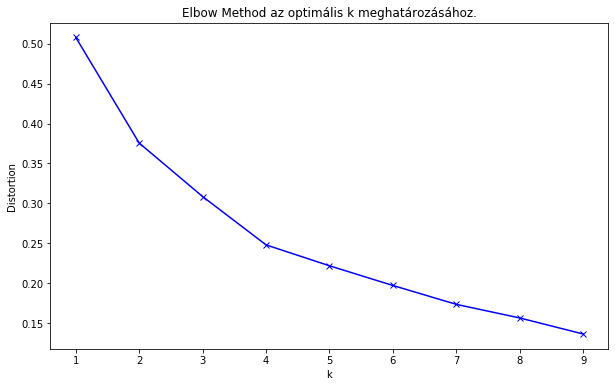

In [69]:
plt.figure(figsize=(10,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method az optimális k meghatározásához.')
plt.show()

In [70]:
# Igaz, csak halványan, de a k=4-nél van az elbow pont, ami miatt, illetve józan ésszel átgondolva is a k=4 mellett döntöttem
# klaszterek számának beállítása

kclusters = 4

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bp_grouped_clustering)

kmeans.labels_[0:23]

array([0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1,
       2])

In [71]:
#bp_merged = bp_merged.drop(['Cluster Labels'], axis=1)

In [72]:
# Klaszter címkék hozzáadás
district_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# 1. merge:
bp_merged = pd.merge(keruletek, mean_per_district[['District', 'Price/m2']])

# 2. merge:
bp_merged = bp_merged.join(district_venues_sorted.set_index('District'), on='District')

bp_merged

,District,Lat,Lon,Price/m2,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Budapest I. kerulete,47.496819,19.034522,3395.196098,0,Bakery,Hotel,Ice Cream Shop,Coffee Shop,Hungarian Restaurant,Café,Bistro,Gym / Fitness Center,Italian Restaurant,Playground
1,Budapest II. kerulete,47.527676,19.002645,3400.325073,1,Park,Restaurant,Dessert Shop,Playground,Grocery Store,Scenic Lookout,Bar,Bakery,Italian Restaurant,Hotel
2,Budapest III. kerulete,47.570096,19.037062,3094.314667,1,Beer Garden,Supermarket,Bakery,Diner,Dessert Shop,Restaurant,Gym,Eastern European Restaurant,Coffee Shop,Hungarian Restaurant
3,Budapest IV. kerulete,47.572625,19.082388,2469.308704,1,Park,Beer Garden,Dessert Shop,Pizza Place,Gym / Fitness Center,Diner,Burger Joint,Bakery,Coffee Shop,Gym
4,Budapest V. kerulete,47.501275,19.048857,4062.948563,0,Coffee Shop,Bakery,Hotel,Park,Ice Cream Shop,Pizza Place,Theater,Historic Site,Dessert Shop,Breakfast Spot
5,Budapest VI. kerulete,47.509224,19.065964,3625.957320,0,Coffee Shop,Hotel,Ice Cream Shop,Bar,Pizza Place,Hungarian Restaurant,Dessert Shop,Beer Bar,Restaurant,Plaza
6,Budapest VII. kerulete,47.501164,19.072947,3201.294000,0,Coffee Shop,Hotel,Ice Cream Shop,Restaurant,Bar,Bakery,Pizza Place,Theater,Burger Joint,Plaza
7,Budapest VIII. kerulete,47.488914,19.078844,2931.291634,0,Coffee Shop,Beer Bar,Park,Theater,Burger Joint,Bakery,Hotel,Bar,Soup Place,Café
8,Budapest IX. kerulete,47.470033,19.085444,3097.740455,1,Music Venue,Park,Gym / Fitness Center,Coffee Shop,Café,Burger Joint,Bar,Cosmetics Shop,Theater,Sporting Goods Shop
9,Budapest X. kerulete,47.483775,19.149783,2722.653947,1,Bakery,Coffee Shop,Supermarket,Cosmetics Shop,Clothing Store,Toy / Game Store,Hungarian Restaurant,Dessert Shop,Fast Food Restaurant,Gym


In [73]:
#megszámlálja, hogy melyik klaszterbe hány kerület található
bp_merged['Cluster Labels'].value_counts()

1    13
0     5
3     4
2     1
Name: Cluster Labels, dtype: int64

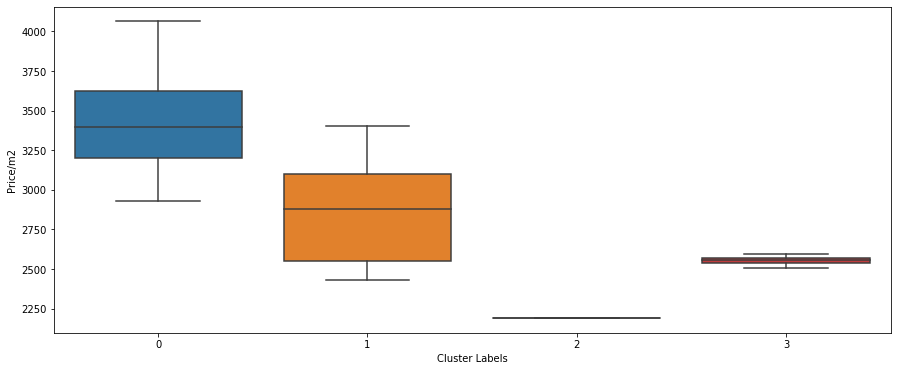

In [74]:
plt.figure(figsize=(15,6))
sns.boxplot(x='Cluster Labels', y='Price/m2', data=bp_merged)

In [75]:
# térkép a klaszterekhez
map_clusters = folium.Map(location=BUDAPEST_CENTER, zoom_start=10)

# színek
rainbow = ['green', 'blue', 'red', 'orange']

# címke hozzáadása
markers_colors = []
for lat, lon, poi, cluster in zip(bp_merged['Lat'], bp_merged['Lon'], bp_merged['District'], bp_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Különböző klaszterek elemzése

### 1. Klaszter

In [76]:
cluster1 = bp_merged.loc[bp_merged['Cluster Labels'] == 0, bp_merged.columns[[0] + list(range(5, bp_merged.shape[1]))]]
cluster1

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Budapest I. kerulete,Bakery,Hotel,Ice Cream Shop,Coffee Shop,Hungarian Restaurant,Café,Bistro,Gym / Fitness Center,Italian Restaurant,Playground
4,Budapest V. kerulete,Coffee Shop,Bakery,Hotel,Park,Ice Cream Shop,Pizza Place,Theater,Historic Site,Dessert Shop,Breakfast Spot
5,Budapest VI. kerulete,Coffee Shop,Hotel,Ice Cream Shop,Bar,Pizza Place,Hungarian Restaurant,Dessert Shop,Beer Bar,Restaurant,Plaza
6,Budapest VII. kerulete,Coffee Shop,Hotel,Ice Cream Shop,Restaurant,Bar,Bakery,Pizza Place,Theater,Burger Joint,Plaza
7,Budapest VIII. kerulete,Coffee Shop,Beer Bar,Park,Theater,Burger Joint,Bakery,Hotel,Bar,Soup Place,Café


### 2. Klaszter

In [77]:
cluster2 = bp_merged.loc[bp_merged['Cluster Labels'] == 1, bp_merged.columns[[0] + list(range(5, bp_merged.shape[1]))]]
cluster2

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Budapest II. kerulete,Park,Restaurant,Dessert Shop,Playground,Grocery Store,Scenic Lookout,Bar,Bakery,Italian Restaurant,Hotel
2,Budapest III. kerulete,Beer Garden,Supermarket,Bakery,Diner,Dessert Shop,Restaurant,Gym,Eastern European Restaurant,Coffee Shop,Hungarian Restaurant
3,Budapest IV. kerulete,Park,Beer Garden,Dessert Shop,Pizza Place,Gym / Fitness Center,Diner,Burger Joint,Bakery,Coffee Shop,Gym
8,Budapest IX. kerulete,Music Venue,Park,Gym / Fitness Center,Coffee Shop,Café,Burger Joint,Bar,Cosmetics Shop,Theater,Sporting Goods Shop
9,Budapest X. kerulete,Bakery,Coffee Shop,Supermarket,Cosmetics Shop,Clothing Store,Toy / Game Store,Hungarian Restaurant,Dessert Shop,Fast Food Restaurant,Gym
10,Budapest XI. kerulete,Coffee Shop,Gym / Fitness Center,Ice Cream Shop,Park,Playground,Bakery,Supermarket,Diner,Burger Joint,Bus Stop
11,Budapest XII. kerulete,Bus Stop,Scenic Lookout,Restaurant,Grocery Store,Playground,Park,Bakery,Dessert Shop,Hungarian Restaurant,Mountain
12,Budapest XIII. kerulete,Park,Coffee Shop,Gym / Fitness Center,Gourmet Shop,Hungarian Restaurant,Dessert Shop,Playground,Spa,Sporting Goods Shop,Island
13,Budapest XIV. kerulete,Gym / Fitness Center,Playground,Gym,Beer Garden,Dessert Shop,Park,Performing Arts Venue,Hungarian Restaurant,Zoo Exhibit,Spa
14,Budapest XV. kerulete,Supermarket,Fast Food Restaurant,Grocery Store,Electronics Store,Bus Stop,Restaurant,Park,Bakery,Coffee Shop,Tram Station


### 3. Klaszter

In [78]:
cluster3 = bp_merged.loc[bp_merged['Cluster Labels'] == 2, bp_merged.columns[[0] + list(range(5, bp_merged.shape[1]))]]
cluster3

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Budapest XXIII. kerulete,Hungarian Restaurant,Bus Station,Train Station,Gas Station,Paper / Office Supplies Store,Buffet,Restaurant,Bakery,Outdoors & Recreation,Hotel


### 4. Klaszter

In [79]:
cluster4 = bp_merged.loc[bp_merged['Cluster Labels'] == 3, bp_merged.columns[[0] + list(range(5, bp_merged.shape[1]))]]
cluster4

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Budapest XVII. kerulete,Bus Stop,Dessert Shop,Supermarket,Plaza,Burger Joint,Train Station,Gym,Diner,Park,Restaurant
17,Budapest XVIII. kerulete,Bus Stop,Supermarket,Grocery Store,Eastern European Restaurant,Ice Cream Shop,Bakery,Gym / Fitness Center,Park,Diner,Tram Station
19,Budapest XX. kerulete,Bus Stop,Park,Supermarket,Pizza Place,Bakery,Restaurant,Dessert Shop,Athletics & Sports,Tram Station,Pharmacy
20,Budapest XXI. kerulete,Bus Stop,Grocery Store,Bakery,Restaurant,Park,Dessert Shop,Beer Garden,Supermarket,Fast Food Restaurant,Pharmacy


## Térképen a klaszterek és az Ár/m2 megjelenítése.
### Látszik, hogy a hasonló kerületek között is mennyire különböző árakon lehet albérletet találni

In [80]:
# Végső térkép a klaszterekkel
budapest_geo = location_data

# sima térkép behívása
budapest_map = folium.Map(location=BUDAPEST_CENTER,tiles='Stamen Toner', zoom_start=10)

# adatok hozzáadása
budapest_map.choropleth(
    geo_data=location_data,
    data=mean_per_district,
    columns=['District', 'Price/m2'],
    key_on='feature.geometry.name',
    fill_color='YlGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Átlagos Ár/m2 a budapesti kerületekben'
)

# színek
marker_colors = ['green', 'blue', 'red', 'orange']

# címkék hozzáadása, a 10 leggyakoribb létesítménnyel és az átlagos Ár/m2-rel
for idx in range(len(bp_merged)):
    html_label = ''
    lat = bp_merged['Lat'].loc[idx]
    lng = bp_merged['Lon'].loc[idx]
    #district_num = (bp_merged['PostalCode'].loc[idx])[1:3]
    district = bp_merged['District'].loc[idx]
    cluster = bp_merged['Cluster Labels'].loc[idx]
    average_price = bp_merged['Price/m2'].loc[idx]
    
    if (cluster == 0):
        area = 'Cluster 1'
    elif (cluster == 1):
        area = 'Cluster 2'
    elif (cluster == 2):
        area = 'Cluster 3'
    elif (cluster == 3):
        area = 'Cluster 4'
    else: area = "NA"
    
    html_label = '<h5>' + district + '</h5><h6><b> Klaszter: </b>' + area + '</h6><h6><b> Atlagos Ar/m2: </b>' + str(average_price.round(2)) + 'HUF </h6><h6><b> Top 10: </b></h6><h6><ol>'
    
    for col in range(5, 15):
        html_label += '<li>' + bp_merged.iloc[idx, col]

    html_label += '</ol></h6>'
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=html_label,
        color=rainbow[cluster],
        fill=True,
        fill_color=marker_colors[cluster],
        fill_opacity=0.7).add_to(budapest_map)

# display map
budapest_map

# Többváltozós lineáris regresszió a lakásárak elemzésére

### A cél, hogy ha kiválasztotta a vevő a számára megfelelő kerületet, tisztább képet kapjon az árakat alakító tényezőkről is, előre lehessen jelezni, körülbelül mekkora árra számíthat, igényeinek megfelelően

In [81]:
df_full.head()

,Unnamed: 0,animals,common_cost,condition,date_scraped,description,elevator,energy_certificate,furniture,garden,heating_type,image_folder_name,image_urls,location,location_str,price,rooms,size,title,type,url,view_type
0,https://ingatlan.jofogas.hu/budapest/07_01_tol...,nem,15000 ft/hó,új építésű,2018/05/06 14:50,Újnak LÁtszÓ (a valóságban 7 éves) BelvÁrosi...,van,a,igen,nem,egyedi mérős központifűtés,e1db7b7b-590d-4c73-ac90-881cd9a30f01,['https://img.jofogas.hu/hdimages/07_01_tol_be...,"(47.5101199, 19.0936737)","Budapest, XIV. kerület, Istvánmező, Thököly...",148000.0,2.0,60.0,"07.01-től belvárosi, 2 szobás berendezett laká...",tégla,https://ingatlan.jofogas.hu/budapest/07_01_tol...,panoráma
1,https://ingatlan.jofogas.hu/budapest/100m2__es...,nem,NaN,felújított,2018/05/06 15:30,Kertvárosi környezetben 4 lakásos társasházb...,nincs,NaN,megegyezés szerint,igen,gáz-cirkó,908b3451-c6d2-40cb-969a-3651110bf3d2,['https://img.jofogas.hu/hdimages/100m2__es_2_...,"(47.5498939, 19.1262642)","Budapest, XV. kerület, Rákospalota, Dessewf...",170000.0,2.0,100.0,"100m2 -es 2,5 szobás lakás Rákospalotán kiadó",tégla,https://ingatlan.jofogas.hu/budapest/100m2__es...,udvari
2,https://ingatlan.jofogas.hu/budapest/106_nm_es...,NaN,NaN,jó állapotú,2018/05/06 14:42,"VII. kerület, Izabella utcában, közös haszná...",van,NaN,igen,NaN,gáz-cirkó,7fac6aad-0d90-4217-8fe2-d2ba0cf2e4dc,['https://img.jofogas.hu/hdimages/106_nm_es__3...,"(47.501195, 19.0711858)","Budapest, VII. kerület, VII. Kerület",190000.0,3.0,106.0,"106 nm-es, 3 szobás, bútorozott, gépesített la...",tégla,https://ingatlan.jofogas.hu/budapest/106_nm_es...,utcai
3,https://ingatlan.jofogas.hu/budapest/106_nm_es...,NaN,NaN,jó állapotú,2018/05/06 14:43,"VII. kerület, Izabella utcában, közös haszná...",van,NaN,igen,NaN,gáz-cirkó,8f9c7d15-a80c-43ae-9b6f-cede11dac08d,['https://img.jofogas.hu/hdimages/106_nm_es__3...,"(47.501195, 19.0711858)","Budapest, VII. kerület, VII. Kerület",190000.0,3.0,106.0,"106 nm-es, 3 szobás, bútorozott, gépesített la...",tégla,https://ingatlan.jofogas.hu/budapest/106_nm_es...,utcai
4,https://ingatlan.jofogas.hu/budapest/106_nm_es...,csak kisebb méretű háziállatok,16000 ft/hó,jó állapotú,2018/05/06 14:55,"V. ker. Kossuth Lajos utca mellékutcájában, ...",van,NaN,nem,NaN,gáz-cirkó,6c61cd28-9595-4471-a4b9-9710bda5551f,['https://img.jofogas.hu/hdimages/106_nm_es_la...,"(47.4950949, 19.0539535)","Budapest, V. kerület",372132.0,3.0,106.0,106 nm-es lakás kiadó Budapest 5. ker. #2269814,tégla,https://ingatlan.jofogas.hu/budapest/106_nm_es...,utcai


In [82]:
# Az érdekesebb változók bevonása
dfreg = df_full[['condition', 'elevator', 'garden', 'price', 'rooms', 'size', 'type']]

In [83]:
dfreg.head()

,condition,elevator,garden,price,rooms,size,type
0,új építésű,van,nem,148000.0,2.0,60.0,tégla
1,felújított,nincs,igen,170000.0,2.0,100.0,tégla
2,jó állapotú,van,NaN,190000.0,3.0,106.0,tégla
3,jó állapotú,van,NaN,190000.0,3.0,106.0,tégla
4,jó állapotú,van,NaN,372132.0,3.0,106.0,tégla


### Adattisztítás

In [84]:
missing_data_dfreg = dfreg.isna()
#missing_data_dfreg.head(5)

In [85]:
for column in missing_data_dfreg.columns.values.tolist():
    print(column)
    print (missing_data_dfreg[column].value_counts())
    print("")

condition
False    2761
True       83
Name: condition, dtype: int64

elevator
False    2840
True        4
Name: elevator, dtype: int64

garden
False    1461
True     1383
Name: garden, dtype: int64

price
False    2812
True       32
Name: price, dtype: int64

rooms
False    2843
True        1
Name: rooms, dtype: int64

size
False    2843
True        1
Name: size, dtype: int64

type
False    2838
True        6
Name: type, dtype: int64



In [176]:
# a Garden változót kivesszük az elemzésből, mert túl sok a hiányzó adat
dfreg = dfreg[['condition', 'elevator', 'price', 'rooms', 'size', 'type']]

In [177]:
dfreg.dropna(inplace= True)
dfreg.shape

(2720, 6)

In [178]:
dfreg['condition'].unique().tolist()

['új építésű', 'felújított', 'jó állapotú', 'újszerű', 'felújítandó']

In [179]:
dfreg['elevator'].unique().tolist()

['van', 'nincs']

In [180]:
dfreg['type'].unique().tolist()

['tégla', 'panel', 'egyéb']

In [181]:
dfreg.head()

,condition,elevator,price,rooms,size,type
0,új építésű,van,148000.0,2.0,60.0,tégla
1,felújított,nincs,170000.0,2.0,100.0,tégla
2,jó állapotú,van,190000.0,3.0,106.0,tégla
3,jó állapotú,van,190000.0,3.0,106.0,tégla
4,jó állapotú,van,372132.0,3.0,106.0,tégla


In [182]:
# szótárak a nominális változók kódolásához
conditions = {'felújítandó': 1,'jó állapotú': 2, 'felújított' : 3, 'újszerű' : 4, 'új építésű' : 5} 
elevators = {'nincs' : 1, 'van' : 2} 
types = {'panel' : 1, 'tégla' : 2,'egyéb' : 3}
  
# alkalmazzuk a dataframe-re
dfreg.condition = [conditions[item] for item in dfreg.condition]
dfreg.elevator = [elevators[item] for item in dfreg.elevator]
dfreg.type = [types[item] for item in dfreg.type]

dfreg.head()

,condition,elevator,price,rooms,size,type
0,5,2,148000.0,2.0,60.0,2
1,3,1,170000.0,2.0,100.0,2
2,2,2,190000.0,3.0,106.0,2
3,2,2,190000.0,3.0,106.0,2
4,2,2,372132.0,3.0,106.0,2


In [183]:
dfreg.dtypes

condition      int64
elevator       int64
price        float64
rooms        float64
size         float64
type           int64
dtype: object

In [184]:
dfreg['elevator'] = dfreg['elevator'].astype(float)
dfreg['condition'] = dfreg['condition'].astype(float)
dfreg['type'] = dfreg['type'].astype(float)

In [185]:
dfreg.describe()

,condition,elevator,price,rooms,size,type
count,2720.000000,2720.000000,2.720000e+03,2720.000000,2720.000000,2720.000000
mean,2.983456,1.562868,3.443926e+05,2.071691,81.794485,1.925735
std,0.875950,0.496123,3.430882e+06,0.950217,863.595892,0.351008
min,1.000000,1.000000,1.200000e+02,1.000000,12.000000,1.000000
25%,2.000000,1.000000,1.290000e+05,1.000000,43.000000,2.000000
50%,3.000000,2.000000,1.550000e+05,2.000000,55.000000,2.000000
75%,3.000000,2.000000,2.300000e+05,3.000000,76.000000,2.000000
max,5.000000,2.000000,1.363774e+08,5.000000,45000.000000,3.000000


In [187]:
# Kiugró értékek kezelése
# Legfelső és legalsó 1% határa
q_low = dfreg["price"].quantile(0.01)
q_hi  = dfreg["price"].quantile(0.99)
print(q_low)
print(q_hi)

75000.0
930000.0


In [190]:
dfreg = dfreg[~(dfreg['price'] > q_hi) & ~(dfreg['price'] < q_low)]

In [191]:
dfreg.describe()

,condition,elevator,price,rooms,size,type
count,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000,2667.000000
mean,2.979753,1.564304,202384.535058,2.055493,80.139858,1.923885
std,0.870649,0.495941,125665.302129,0.923517,870.687905,0.350516
min,1.000000,1.000000,75000.000000,1.000000,12.000000,1.000000
25%,2.000000,1.000000,130000.000000,1.000000,43.000000,2.000000
50%,3.000000,2.000000,155000.000000,2.000000,55.000000,2.000000
75%,3.000000,2.000000,230000.000000,3.000000,75.000000,2.000000
max,5.000000,2.000000,930000.000000,5.000000,45000.000000,3.000000


In [193]:
sizes = dfreg["size"]
sorted(sizes, reverse=True)[:10]

[45000.0, 389.0, 384.0, 300.0, 280.0, 270.0, 240.0, 236.0, 234.0, 220.0]

In [197]:
dfreg = dfreg[(dfreg['size'] < 45000)]
dfreg.describe()

,condition,elevator,price,rooms,size,type
count,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,2.978995,1.564141,202411.686047,2.055514,63.290698,1.923856
std,0.869932,0.495962,125681.052626,0.923689,30.854289,0.350579
min,1.000000,1.000000,75000.000000,1.000000,12.000000,1.000000
25%,2.000000,1.000000,130000.000000,1.000000,43.000000,2.000000
50%,3.000000,2.000000,155000.000000,2.000000,55.000000,2.000000
75%,3.000000,2.000000,230000.000000,3.000000,75.000000,2.000000
max,5.000000,2.000000,930000.000000,5.000000,389.000000,3.000000


#### Adattisztítás miatt bevonom ide is a Price/m2 változót

In [226]:
dfreg['Price/m2'] = (dfreg['price']/dfreg['size']).round(2)

In [227]:
dfreg.describe()

,condition,elevator,price,rooms,size,type,Price/m2
count,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000,2666.000000
mean,2.978995,1.564141,202411.686047,2.055514,63.290698,1.923856,3236.677749
std,0.869932,0.495962,125681.052626,0.923689,30.854289,0.350579,1070.860906
min,1.000000,1.000000,75000.000000,1.000000,12.000000,1.000000,901.960000
25%,2.000000,1.000000,130000.000000,1.000000,43.000000,2.000000,2500.000000
50%,3.000000,2.000000,155000.000000,2.000000,55.000000,2.000000,3000.000000
75%,3.000000,2.000000,230000.000000,3.000000,75.000000,2.000000,3714.290000
max,5.000000,2.000000,930000.000000,5.000000,389.000000,3.000000,13333.330000


In [229]:
# Kiugró értékek kezelése
# Legfelső és legalsó 1% határa
q_low = dfreg["Price/m2"].quantile(0.01)
q_hi  = dfreg["Price/m2"].quantile(0.99)
print(q_low)
print(q_hi)

1684.8845000000001
6926.901999999999


In [230]:
dfreg = dfreg[~(dfreg['Price/m2'] > q_hi) & ~(dfreg['Price/m2'] < q_low)]

In [231]:
dfreg.describe()

,condition,elevator,price,rooms,size,type,Price/m2
count,2612.000000,2612.000000,2612.000000,2612.000000,2612.000000,2612.000000,2612.000000
mean,2.981623,1.564319,200897.739663,2.049005,62.985835,1.922665,3204.163446
std,0.870628,0.495941,123145.185923,0.919537,30.076823,0.353555,933.324381
min,1.000000,1.000000,75000.000000,1.000000,14.000000,1.000000,1686.750000
25%,2.000000,1.000000,130000.000000,1.000000,43.000000,2.000000,2539.680000
50%,3.000000,2.000000,150000.000000,2.000000,55.000000,2.000000,3000.000000
75%,3.000000,2.000000,229250.000000,3.000000,75.000000,2.000000,3703.700000
max,5.000000,2.000000,930000.000000,5.000000,389.000000,3.000000,6923.080000


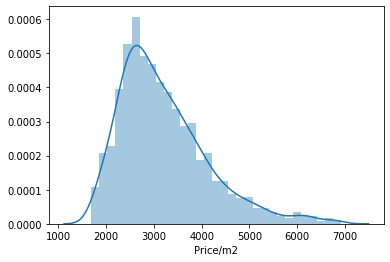

In [233]:
sns.distplot(dfreg['Price/m2'])

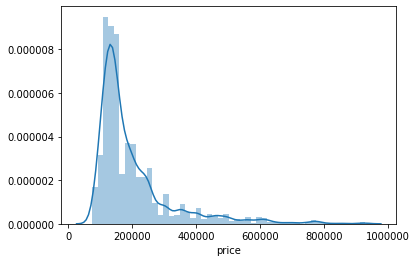

In [262]:
sns.distplot(dfreg['price'])

In [234]:
# 2464 adatponttal dolgozunk
dfreg.shape

(2612, 7)

### Boxplot diagrammok

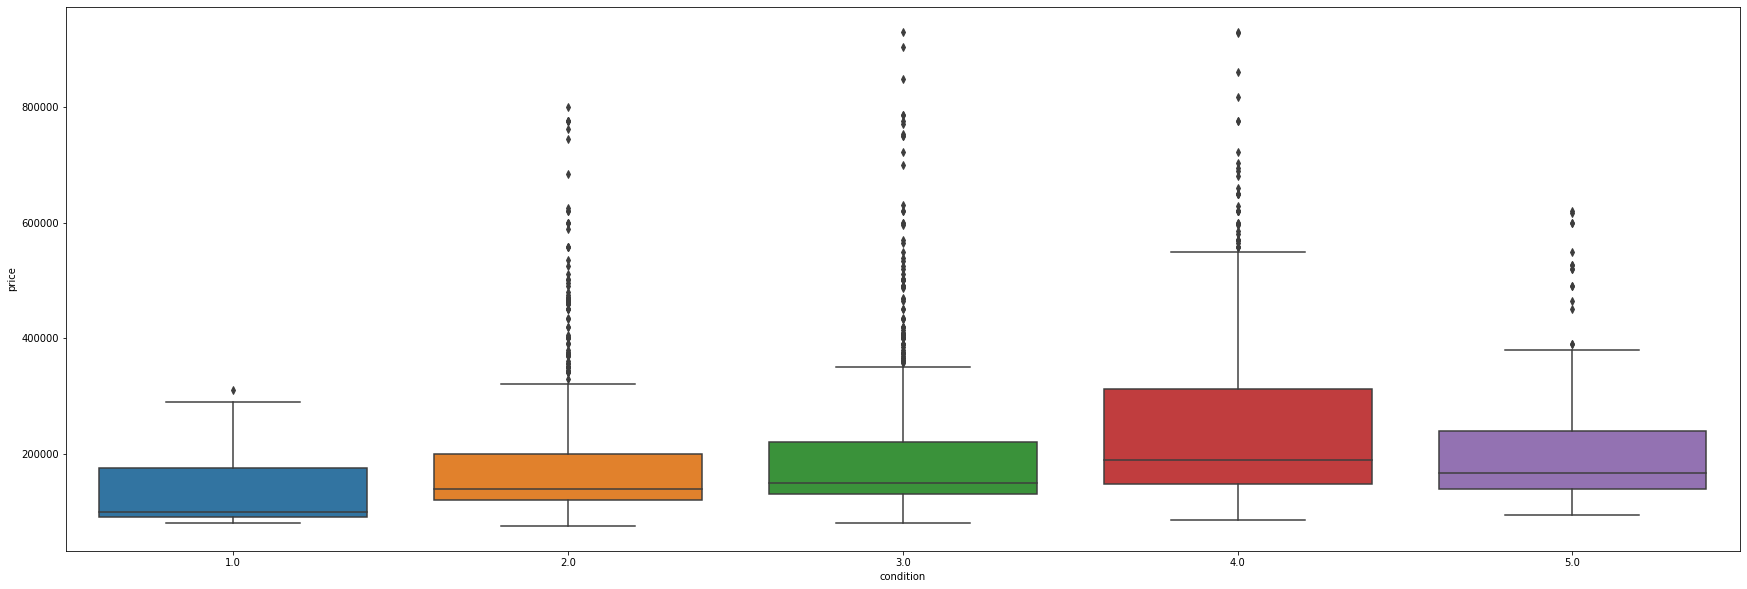

In [235]:
# A lakás állapota alapján
plt.figure(figsize=(30,10))
sns.boxplot(x='condition', y='price', data=dfreg)

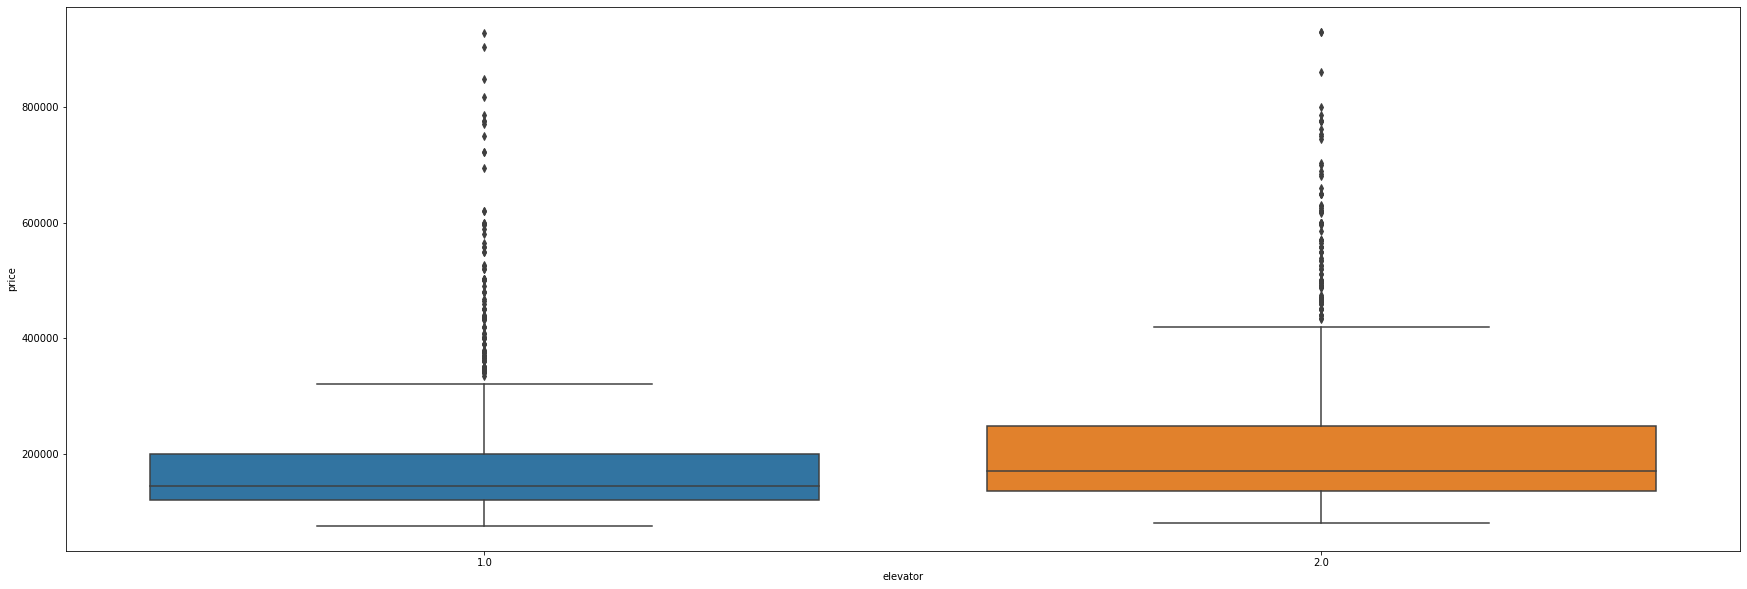

In [236]:
# Van-e lift vagy nincs?
plt.figure(figsize=(30,10))
sns.boxplot(x='elevator', y='price', data=dfreg)

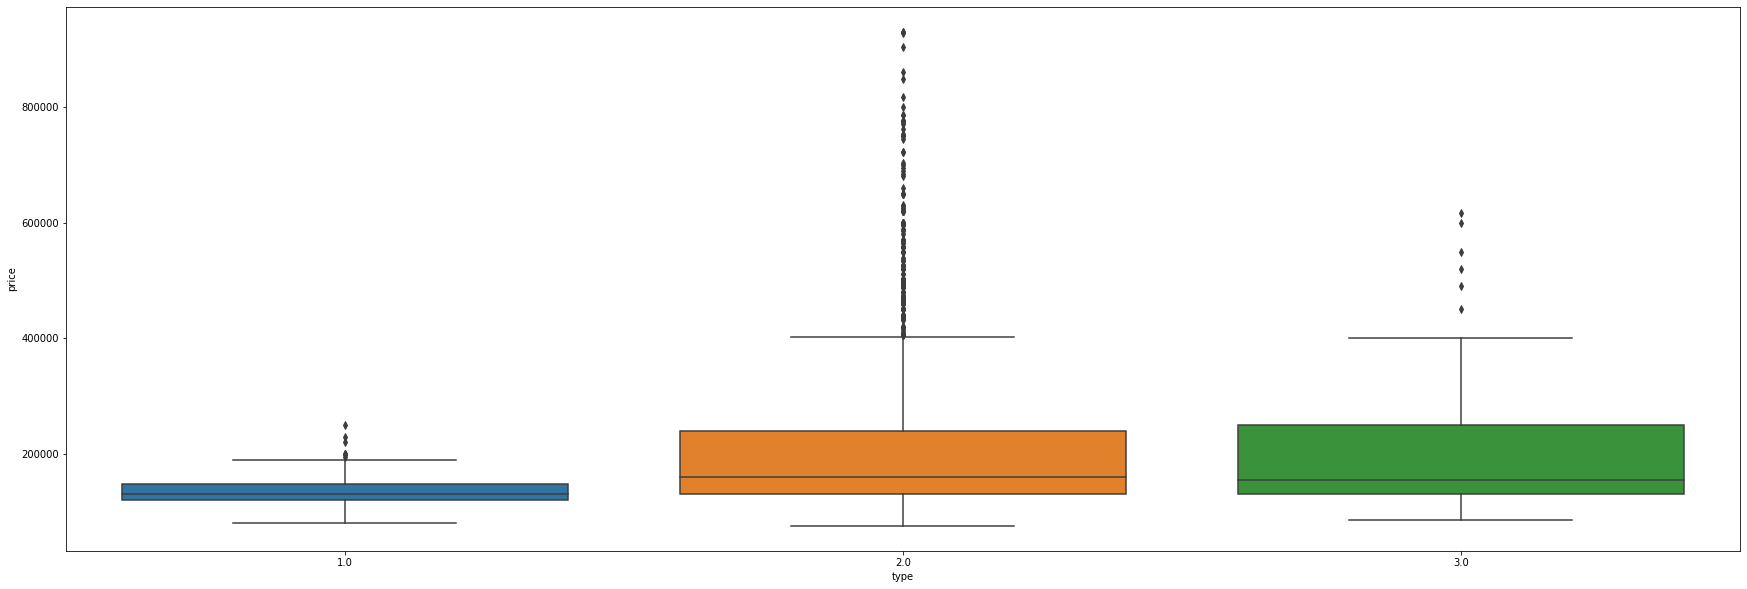

In [237]:
# Épület típusa
plt.figure(figsize=(30,10))
sns.boxplot(x='type', y='price', data=dfreg)

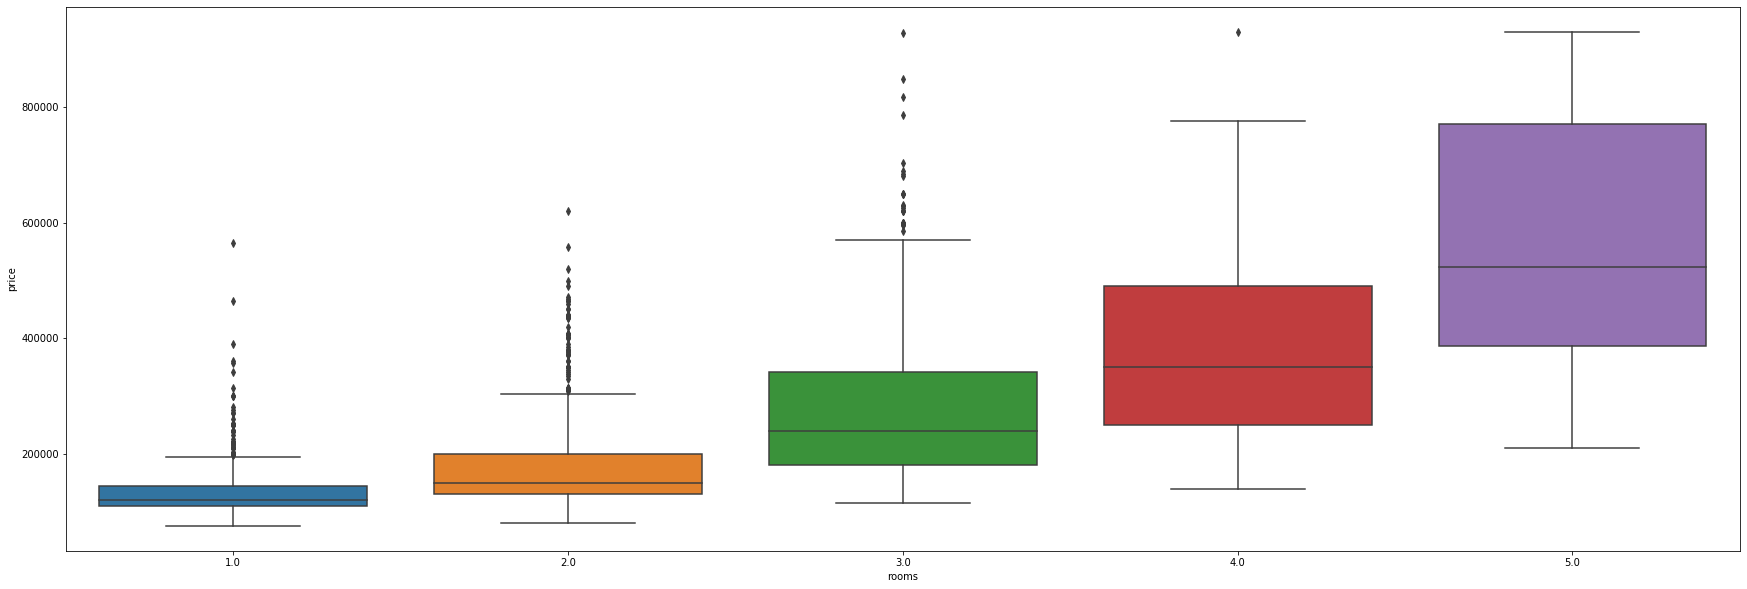

In [238]:
# Szobák száma
plt.figure(figsize=(30,10))
sns.boxplot(x='rooms', y='price', data=dfreg)

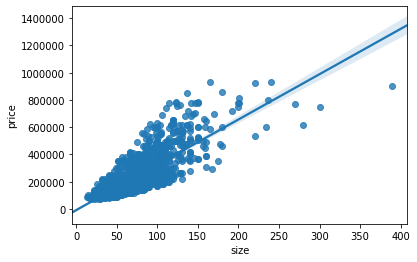

In [239]:
# Lakás alapterületének a függvényében az ár alakulása, regressziós diagramon
sizeplot = sns.regplot(x="size", y="price", data=dfreg)

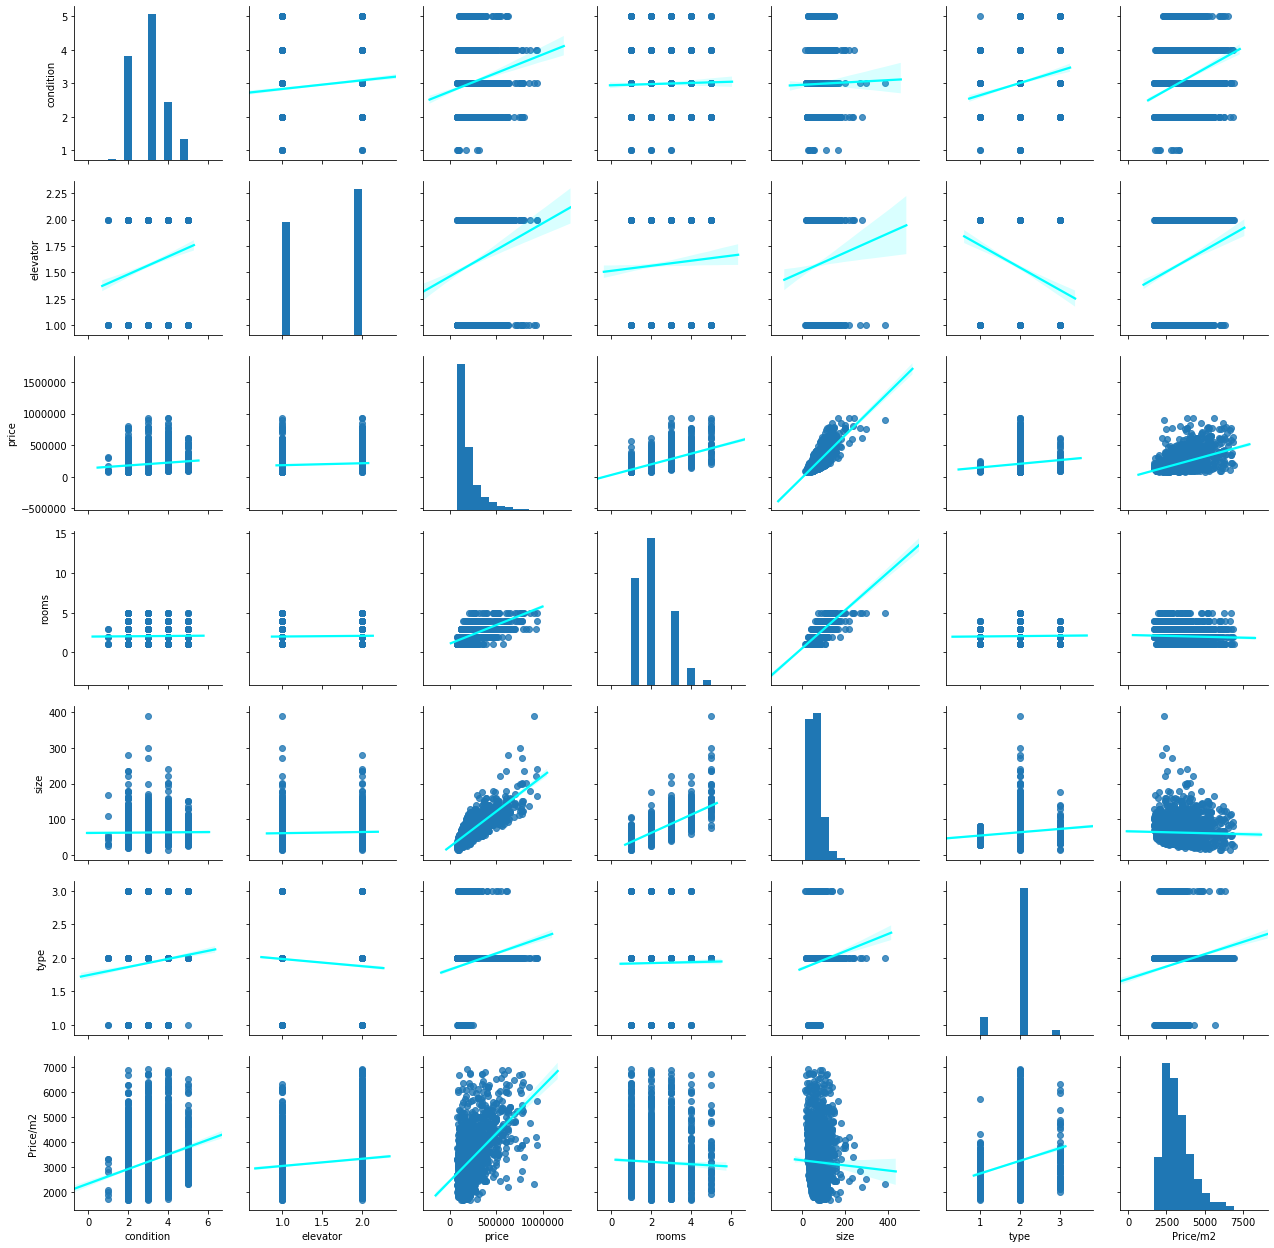

In [240]:
# Páros diagramok
sns.pairplot(dfreg, kind='reg', plot_kws={'line_kws':{'color': 'cyan'}})
plt.show()

### Korreláció elemzés

##### Látszik, hogy a size és a rooms változó szorosan összefüggnek, ezért a rooms váltizót kiveszem a modellből, egyébként gyenge pozitív irányú kapcsolat figyelhető meg a többi magyarázóváltozóval

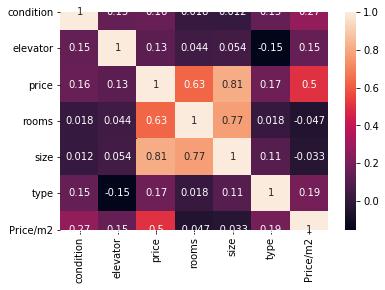

In [241]:
sns.heatmap(dfreg.corr(), annot=True)

In [242]:
# A Rooms, illetve a Price/m2 változót nem foglalom bele az elemzésbe, mivel szorosan összefügg a Size változóval, függ attól

X = dfreg[['condition', 'elevator',
               'size', 'type']]
y = dfreg['price']

## Modell kialakítása

In [243]:
# dataset felszabdalása
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [244]:
# ez a függvény a kiertékelésnél segít, kiíratja a fontosabb mérőszámokat
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)

In [245]:
lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [246]:
# tengelymetszet (b0)
print(lin_reg.intercept_)

-136362.68370721652


In [247]:
# Az együtthatók kiíratása
coeff_df = pd.DataFrame(lin_reg.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
condition,16783.211010
elevator,19320.329505
size,3275.293578
type,26506.148770


In [248]:
pred = lin_reg.predict(X_test)

Text(0, 0.5, 'Jósolt értékek')

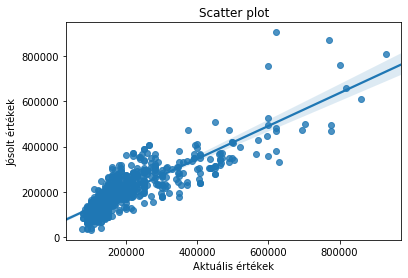

In [249]:
sns.regplot(y_test, pred, fit_reg = True)

plt.title('Scatter plot')
# Set x-axis label
plt.xlabel('Aktuális értékek')
# Set y-axis label
plt.ylabel('Jósolt értékek')

In [250]:
# A fontosabb mérőszámok
print_evaluate(y_test, lin_reg.predict(X_test))

MAE: 44544.96969474073
MSE: 3961208467.4710355
RMSE: 62938.1320621373
R2 Square 0.7260728470750181


In [251]:
regpred = pd.DataFrame({'Aktuális': y_test, 'Jósolt': pred})
regpred10 = regpred.tail(10)

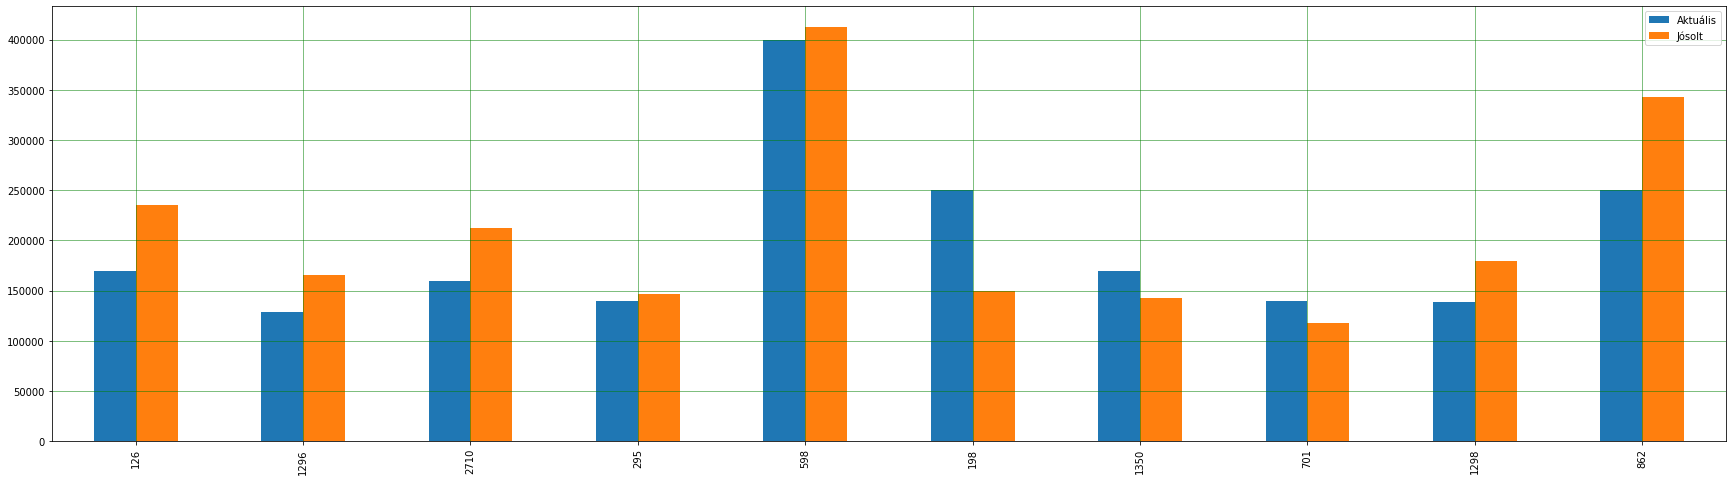

In [252]:
regpred10.plot(kind='bar',figsize=(30,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## Modell készítése Gradient Boosting algoritmussal, érdekesség

In [253]:
# meghatározzuk a paramétereket, nekem 0,03 learning rate-tel érte el a legkisebb RMSE-t
params = {'learning_rate': [0.03], 'loss': ['huber'], 'max_depth': [2], 'max_features': ['log2'], 'min_samples_leaf': [14], 
          'min_samples_split': [10], 'n_estimators': [3000]}


grad_boost = GradientBoostingRegressor(learning_rate=0.03, loss='huber', max_depth=2, 
                                       max_features='log2', min_samples_leaf=14, min_samples_split=10, n_estimators=3000,
                                       random_state=42)


grad_boost.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.03, loss='huber', max_depth=2,
                          max_features='log2', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=14, min_samples_split=10,
                          min_weight_fraction_leaf=0.0, n_estimators=3000,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [254]:
# predikció készítése
y_pred = grad_boost.predict(X_test)
gboost_mse = mean_squared_error(y_test, y_pred)
gboost_rmse = np.sqrt(gboost_mse)
gboost_rmse

59627.64774517226

In [255]:
gradboostpred = pd.DataFrame({'Aktuális': y_test, 'Jósolt': y_pred})
gradboostpred10 = gradboostpred.tail(10)

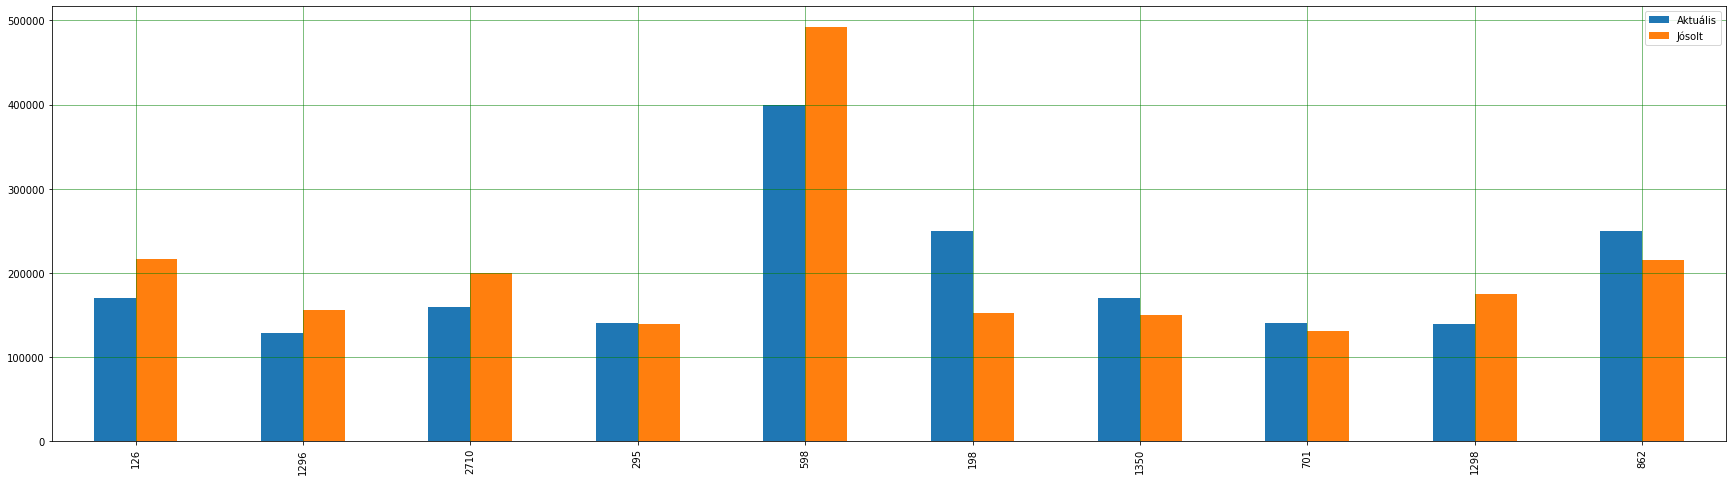

In [256]:
gradboostpred10.plot(kind='bar',figsize=(30,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## Látható, hogy elég nagy hibával dolgozik mindkét modell, ezt magyarázza a független változók száma, illetve típusa.
#### Lineáris Regressziónál a Root Mean Squared Error: 62938.1320621373
#### Grádiens Turbózással pedig: 59627.64774517226
## Viszont használható azért minkét modell egy becslés készítésére az aktuális ügyfélnek.